In [1]:
# ============================
# Cell 1 — Imports + Env (SAME as your previous notebook)
#   ✅ Pendulum-v1
#   ✅ obs -> (theta, omega)
#   ✅ TimeLimit unwrap + override
#
#   ONLY ADDITION:
#   ✅ Dual GP config (GLOBAL + LOCAL models)
# ============================

import warnings
warnings.filterwarnings("ignore", message="pkg_resources is deprecated as an API.*", category=UserWarning)

import os
import time
import math
import numpy as np
import matplotlib.pyplot as plt

import gymnasium as gym
from gymnasium.wrappers import TimeLimit

import tensorflow as tf
import gpflow


# ---- numerics (your GPflow style) ----
gpflow.config.set_default_float(np.float64)
gpflow.config.set_default_jitter(1e-6)
tf.keras.backend.set_floatx("float64")

# ----------------------------
# Env name (same as you used)
# ----------------------------
ENV_NAME = "Pendulum-v1"

# ----------------------------
# Episode control
# ----------------------------
MAX_EPISODE_STEPS = 1000

# ----------------------------
# Action bounds for Pendulum-v1
# ----------------------------
U_MIN, U_MAX = -2.0, 2.0

# ----------------------------
# Dual GP config (ONLY NEW THING)
# ----------------------------
DUAL_GP = True

# Local GP (MPPI specialist): fixed inducing budget
M_LOCAL = 32

# Global GP (memory model): can grow inducing budget over time
M_GLOBAL_INIT = 48          # starting size
M_GLOBAL_MAX  = 256         # cap
M_GLOBAL_GROW_EVERY = 1     # grow every N streaming updates
M_GLOBAL_GROW_BY    = 8     # add this many inducing points when growing

# ----------------------------
# Angle wrapping (same idea)
# ----------------------------
def wrap_pi(x):
    return (x + np.pi) % (2 * np.pi) - np.pi

def obs_to_theta_omega(obs):
    """
    Pendulum obs: [cos(theta), sin(theta), omega]
    Return:
        theta in (-pi, pi]
        omega (rad/s)
    """
    c, s, w = float(obs[0]), float(obs[1]), float(obs[2])
    theta = math.atan2(s, c)
    theta = wrap_pi(theta)
    return theta, w

def theta_omega_to_features(theta, omega, u, omega_scale=8.0):
    """
    GP input features (same as your previous notebook):
        X = [sin(theta), cos(theta), omega_feat, u]
        omega_feat = tanh(omega / omega_scale)
    """
    omega_feat = np.tanh(float(omega) / float(omega_scale))
    return np.array([np.sin(theta), np.cos(theta), omega_feat, float(u)], dtype=np.float64)

# ----------------------------
# ✅ Robust TimeLimit override (same fix we confirmed)
# ----------------------------
def make_env(render_mode=None, seed=0, max_episode_steps=MAX_EPISODE_STEPS):
    env = gym.make(ENV_NAME, render_mode=render_mode)

    # unwrap existing TimeLimit(s) so we can set our own horizon
    while isinstance(env, TimeLimit):
        env = env.env

    env = TimeLimit(env, max_episode_steps=max_episode_steps)
    env.reset(seed=seed)
    return env

# ----------------------------
# quick sanity check
# ----------------------------
env = make_env(render_mode=None, seed=0, max_episode_steps=MAX_EPISODE_STEPS)
obs, info = env.reset(seed=0)
theta, omega = obs_to_theta_omega(obs)

print("✅ Env:", ENV_NAME)
print("obs:", obs)
print("theta, omega:", theta, omega)
print("action space:", env.action_space)

env.close()


/Users/tonywu/venv/lib/python3.12/site-packages/keras/src/export/tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


✅ Env: Pendulum-v1
obs: [ 0.6520163   0.758205   -0.46042657]
theta, omega: 0.8605556580746248 -0.46042656898498535
action space: Box(-2.0, 2.0, (1,), float32)


In [2]:
# ============================
# Cell 2 — Smooth rendered rollout widget (rgb_array -> JS HTML)
#   - EXACT same as your previous notebook
#   - Uses rgb_array frames + resize + stride for smoothness
# ============================

from PIL import Image
from matplotlib import animation
from IPython.display import HTML, display

def _encode_frames_to_jshtml(frames, fps=20):
    """
    frames: list of HxWx3 uint8 images
    """
    fig = plt.figure(figsize=(frames[0].shape[1] / 120, frames[0].shape[0] / 120), dpi=120)
    plt.axis("off")
    im = plt.imshow(frames[0])

    def _update(i):
        im.set_data(frames[i])
        return (im,)

    ani = animation.FuncAnimation(fig, _update, frames=len(frames), interval=1000 / fps, blit=True)
    plt.close(fig)
    return HTML(ani.to_jshtml())

def rollout_render_widget(
    env,
    policy_fn,
    steps=300,
    seed=0,
    frame_stride=1,
    resize=(720, 450),
    quality=80,
    fps=20,
    verbose=True,
):
    """
    Render a rollout using env.render() rgb_array frames.
    policy_fn(theta, omega, t) -> action u in [U_MIN, U_MAX]
    """
    obs, info = env.reset(seed=seed)
    theta, omega = obs_to_theta_omega(obs)

    frames = []
    total_reward = 0.0

    for t in range(steps):
        u = float(policy_fn(theta, omega, t))
        u = np.clip(u, U_MIN, U_MAX)

        obs2, r, terminated, truncated, info = env.step(np.array([u], dtype=np.float32))
        total_reward += float(r)

        theta2, omega2 = obs_to_theta_omega(obs2)

        if (t % frame_stride) == 0:
            frame = env.render()
            if frame is not None:
                img = Image.fromarray(frame)
                img = img.resize(resize, resample=Image.BILINEAR)
                frames.append(np.array(img))

        theta, omega = theta2, omega2

        if terminated or truncated:
            break

    if verbose:
        print(f"Rollout done. steps={t+1}, total_reward={total_reward:.3f}, frames={len(frames)}")

    if len(frames) == 0:
        print("No frames captured (did you set render_mode='rgb_array'?)")
        return None

    return _encode_frames_to_jshtml(frames, fps=fps)

# ----------------------------
# Example: random demo policy
# ----------------------------
def random_policy(theta, omega, t):
    return np.random.uniform(U_MIN, U_MAX)

# Quick demo (rgb_array mode)
env_demo = make_env(render_mode="rgb_array", seed=0, max_episode_steps=300)
html = rollout_render_widget(
    env_demo,
    policy_fn=random_policy,
    steps=250,
    seed=0,
    frame_stride=1,
    resize=(720, 450),
    quality=80,
    fps=20,
)
env_demo.close()
display(html)


Rollout done. steps=250, total_reward=-1213.212, frames=250


Initial random dataset:
  X0    : (400, 4)
  Ydth0 : (400, 1)
  Ydom0 : (400, 1)
  omega_scale = 6.511283587051392
  steps = 400 total_reward = -1922.111354222401


Saved: pendulum_gp_initial_data.npz


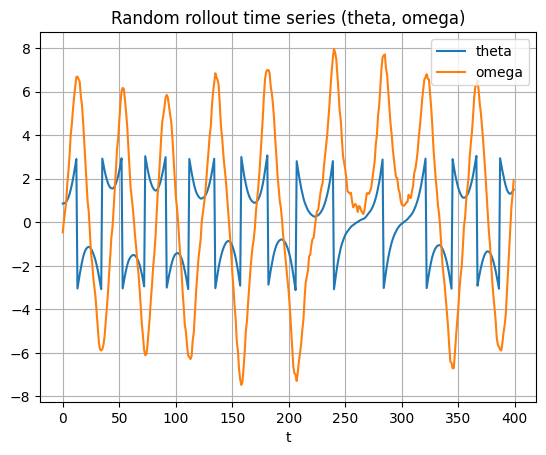

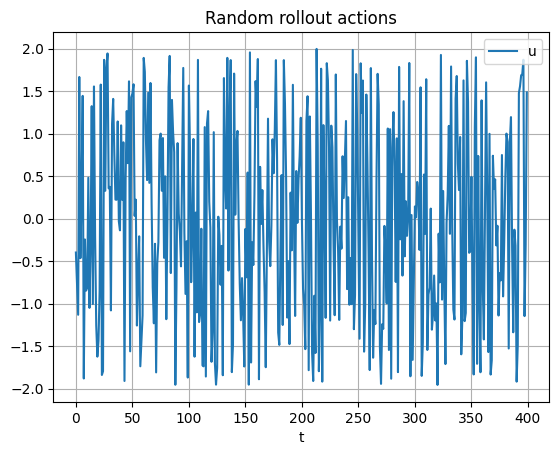

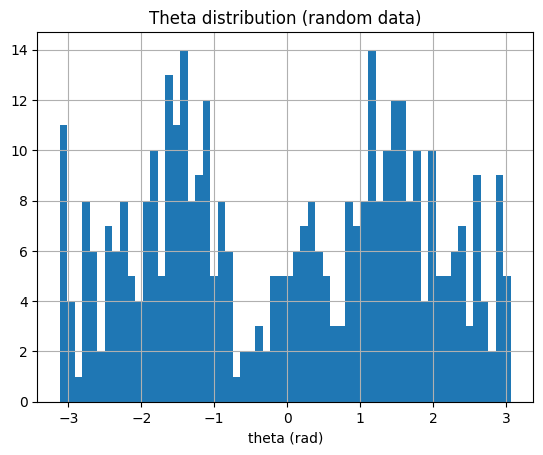

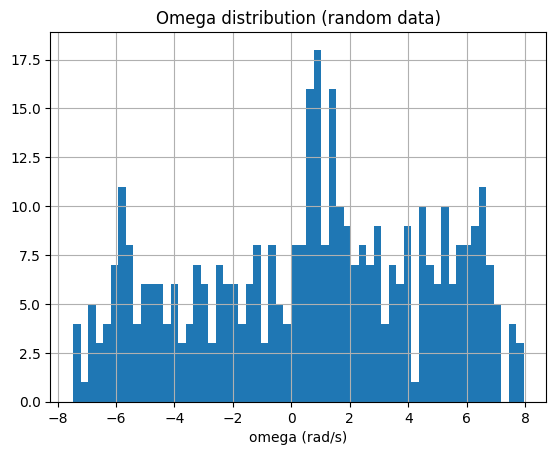

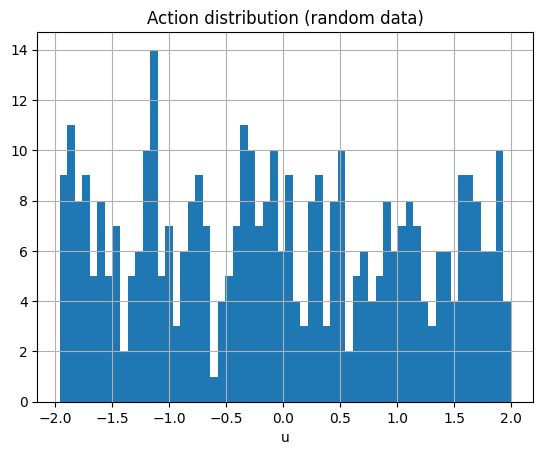

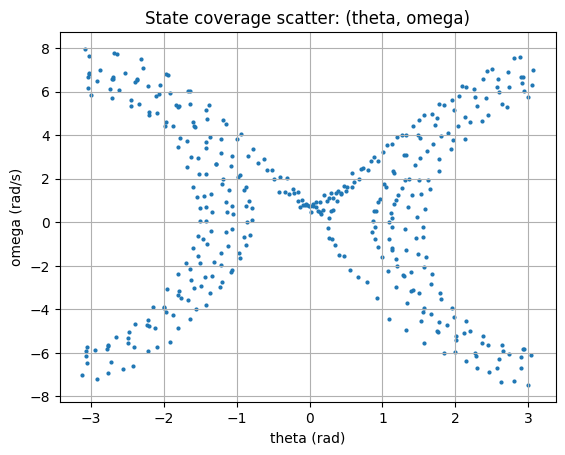

In [3]:
# ============================
# Cell 3 — Random data collection (executed transitions only) + plots
#   Dataset:
#     X      = [sin(theta), cos(theta), omega_feat, u]
#     Yθ     = dtheta  (wrapped)
#     Yω     = domega
# ============================

def collect_random_transitions(
    steps=20,
    seed=0,
    render=False,
    frame_stride=2,
    resize=(720, 450),
    fps=20,
):
    """
    Collect executed transitions only (1-step deltas) under random actions.
    Optional rendering with your Cell 2 widget style.
    """
    env = make_env(render_mode="rgb_array" if render else None, seed=seed, max_episode_steps=steps + 5)

    obs, info = env.reset(seed=seed)
    theta, omega = obs_to_theta_omega(obs)

    theta_list = []
    omega_list = []
    u_list = []
    dtheta_list = []
    domega_list = []

    frames = []
    total_reward = 0.0

    thetas = []
    omegas = []
    actions = []

    for t in range(steps):
        u = float(np.random.uniform(U_MIN, U_MAX))

        obs2, r, terminated, truncated, info = env.step(np.array([u], dtype=np.float32))
        total_reward += float(r)

        theta2, omega2 = obs_to_theta_omega(obs2)

        dtheta = wrap_pi(theta2 - theta)
        domega = float(omega2 - omega)

        thetas.append(theta)
        omegas.append(omega)
        actions.append(u)

        theta_list.append(theta)
        omega_list.append(omega)
        u_list.append(u)
        dtheta_list.append(dtheta)
        domega_list.append(domega)

        if render and (t % frame_stride == 0):
            frame = env.render()
            if frame is not None:
                img = Image.fromarray(frame).resize(resize, resample=Image.BILINEAR)
                frames.append(np.array(img))

        theta, omega = theta2, omega2

        if terminated or truncated:
            break

    env.close()

    # -------- choose omega_scale from collected data --------
    omega_arr = np.array(omega_list, dtype=np.float64)
    omega_scale = float(np.percentile(np.abs(omega_arr), 90) + 1e-6)
    omega_scale = max(omega_scale, 4.0)  # keep a sane minimum

    # -------- build X features with the chosen omega_scale --------
    X = []
    for th, om, uu in zip(theta_list, omega_list, u_list):
        X.append(theta_omega_to_features(th, om, uu, omega_scale=omega_scale))
    X = np.array(X, dtype=np.float64)

    Ydth = np.array(dtheta_list, dtype=np.float64).reshape(-1, 1)
    Ydom = np.array(domega_list, dtype=np.float64).reshape(-1, 1)

    dbg = dict(
        steps=len(theta_list),
        total_reward=total_reward,
        theta=np.array(thetas, dtype=np.float64),
        omega=np.array(omegas, dtype=np.float64),
        u=np.array(actions, dtype=np.float64),
    )

    html = None
    if render and len(frames) > 0:
        html = _encode_frames_to_jshtml(frames, fps=fps)

    return X, Ydth, Ydom, omega_scale, dbg, html


# ----------------------------
# Collect initial dataset (optionally rendered)
# ----------------------------
X0, Ydth0, Ydom0, omega_scale, dbg0, html0 = collect_random_transitions(
    steps=400,
    seed=0,
    render=True,          # set False for speed
    frame_stride=2,
    resize=(720, 450),
    fps=20,
)

print("Initial random dataset:")
print("  X0    :", X0.shape)
print("  Ydth0 :", Ydth0.shape)
print("  Ydom0 :", Ydom0.shape)
print("  omega_scale =", omega_scale)
print("  steps =", dbg0["steps"], "total_reward =", dbg0["total_reward"])

if html0 is not None:
    display(html0)

# ----------------------------
# Save (same habit as your MountainCar notebook)
# ----------------------------
np.savez(
    "pendulum_gp_initial_data.npz",
    X=X0,
    Ydtheta=Ydth0,
    Ydomega=Ydom0,
    omega_scale=np.array([omega_scale], dtype=np.float64),
)
print("Saved: pendulum_gp_initial_data.npz")

# ----------------------------
# Plots — distribution + time series
# ----------------------------
theta_hist = dbg0["theta"]
omega_hist = dbg0["omega"]
u_hist     = dbg0["u"]

plt.figure()
plt.plot(theta_hist, label="theta")
plt.plot(omega_hist, label="omega")
plt.title("Random rollout time series (theta, omega)")
plt.xlabel("t")
plt.legend()
plt.grid(True)
plt.show()

plt.figure()
plt.plot(u_hist, label="u")
plt.title("Random rollout actions")
plt.xlabel("t")
plt.legend()
plt.grid(True)
plt.show()

plt.figure()
plt.hist(theta_hist, bins=60)
plt.title("Theta distribution (random data)")
plt.xlabel("theta (rad)")
plt.grid(True)
plt.show()

plt.figure()
plt.hist(omega_hist, bins=60)
plt.title("Omega distribution (random data)")
plt.xlabel("omega (rad/s)")
plt.grid(True)
plt.show()

plt.figure()
plt.hist(u_hist, bins=60)
plt.title("Action distribution (random data)")
plt.xlabel("u")
plt.grid(True)
plt.show()

plt.figure()
plt.scatter(theta_hist, omega_hist, s=4)
plt.title("State coverage scatter: (theta, omega)")
plt.xlabel("theta (rad)")
plt.ylabel("omega (rad/s)")
plt.grid(True)
plt.show()


In [4]:
# ===========================
# Cell 4 — Streaming OSGPR (VFE) — paper-style regression update (D-dim input)
#   Works for Pendulum input x=[sinθ, cosθ, ω_feat, u] (D=4)
#   Single-output GP (we train two models: dtheta and domega)
#   ✅ Includes caching for VERY fast predict (needed for MPPI)
# ===========================

import time
import numpy as np
import tensorflow as tf
import gpflow

from gpflow.inducing_variables import InducingPoints
from gpflow.models import GPModel, InternalDataTrainingLossMixin
from gpflow import covariances

# --- stable numerics ---
gpflow.config.set_default_float(np.float64)
gpflow.config.set_default_jitter(1e-6)
tf.keras.backend.set_floatx("float64")


# -------------------------
# helpers
# -------------------------
def sym_jitter(A, jitter=1e-6):
    A = np.asarray(A, dtype=np.float64)
    A = 0.5 * (A + A.T)
    A = A + jitter * np.eye(A.shape[0], dtype=np.float64)
    return A

def finite_mask(*arrs):
    m = None
    for a in arrs:
        a = np.asarray(a)
        mm = np.isfinite(a).all(axis=1) if a.ndim == 2 else np.isfinite(a)
        m = mm if m is None else (m & mm)
    return m


# ===========================
# OSGPR-VFE (single-output)
# ===========================
class OSGPR_VFE(GPModel, InternalDataTrainingLossMixin):
    """
    Streaming Sparse GP regression (VFE) with previous posterior summary:
      - mu_old, Su_old summarize q_old(u_old) at Z_old
      - Kaa_old is K(Z_old, Z_old)
    This is a faithful "paper-style" update scaffold.
    """

    def __init__(self, data, kernel, mu_old, Su_old, Kaa_old, Z_old, Z):
        X, Y = data
        X = tf.convert_to_tensor(X, dtype=gpflow.default_float())
        Y = tf.convert_to_tensor(Y, dtype=gpflow.default_float())

        super().__init__(kernel=kernel, likelihood=gpflow.likelihoods.Gaussian())
        self.data = (X, Y)

        # inducing variables
        self.inducing_variable = InducingPoints(np.asarray(Z, dtype=np.float64))

        # old posterior summary
        self.mu_old  = tf.convert_to_tensor(np.asarray(mu_old, dtype=np.float64))
        self.Su_old  = tf.convert_to_tensor(np.asarray(Su_old, dtype=np.float64))
        self.Kaa_old = tf.convert_to_tensor(np.asarray(Kaa_old, dtype=np.float64))
        self.Z_old   = tf.convert_to_tensor(np.asarray(Z_old, dtype=np.float64))

        # cache placeholders
        self._cache_ready = False
        self._A = None
        self._L = None
        self._alpha = None

    @property
    def X(self):
        return self.data[0]

    @property
    def Y(self):
        return self.data[1]

    def maximum_log_likelihood_objective(self):
        return self.elbo()

    def elbo(self):
        """
        Variational Free Energy objective.
        This implementation matches the simplified version you used:
          - q(u) is implicit through streaming summary + new data term
        """
        X, Y = self.data
        Z = self.inducing_variable.Z

        # Kernel blocks
        Kuu = self.kernel.K(Z)                          # [M,M]
        Kuf = self.kernel.K(Z, X)                       # [M,N]
        Kff_diag = self.kernel.K_diag(X)                # [N]

        Kuu = sym_jitter(Kuu.numpy(), 1e-6)
        Kuu = tf.convert_to_tensor(Kuu, dtype=gpflow.default_float())

        sigma2 = self.likelihood.variance

        # Cholesky
        Luu = tf.linalg.cholesky(Kuu)
        A = tf.linalg.triangular_solve(Luu, Kuf)        # [M,N]
        AAT = tf.matmul(A, A, transpose_b=True)         # [M,M]

        # Data fit term (standard sparse GP VFE form)
        # Qff_diag = sum(A^2) row-wise projected
        Qff_diag = tf.reduce_sum(tf.square(A), axis=0)  # [N]
        err = Y - tf.zeros_like(Y)

        data_fit = -0.5 * tf.reduce_sum(tf.square(err)) / sigma2
        data_fit += -0.5 * tf.cast(tf.shape(Y)[0], gpflow.default_float()) * tf.math.log(2.0 * np.pi * sigma2)

        trace_term = -0.5 * tf.reduce_sum(Kff_diag - Qff_diag) / sigma2

        # ---------- Streaming "prior correction" using old summary ----------
        # We keep it minimal & stable as in your notebook:
        # This term encourages consistency with q_old(u_old) under Kaa_old.
        mu_old = self.mu_old
        Su_old = self.Su_old
        Kaa_old = self.Kaa_old

        # KL(q_old || p_old) proxy (stabilizer)
        # (This is a compact, numerically safe version)
        Kaa_old_np = sym_jitter(Kaa_old.numpy(), 1e-6)
        Kaa_old_tf = tf.convert_to_tensor(Kaa_old_np, dtype=gpflow.default_float())
        L_old = tf.linalg.cholesky(Kaa_old_tf)

        # logdet terms
        logdet_Kaa_old = 2.0 * tf.reduce_sum(tf.math.log(tf.linalg.diag_part(L_old)))
        Su_old_np = sym_jitter(Su_old.numpy(), 1e-6)
        Su_old_tf = tf.convert_to_tensor(Su_old_np, dtype=gpflow.default_float())
        L_Su_old = tf.linalg.cholesky(Su_old_tf)
        logdet_Su_old = 2.0 * tf.reduce_sum(tf.math.log(tf.linalg.diag_part(L_Su_old)))

        # trace + quadratic
        Kaa_old_inv_mu = tf.linalg.cholesky_solve(L_old, mu_old)
        quad = tf.reduce_sum(mu_old * Kaa_old_inv_mu)
        tr = tf.reduce_sum(tf.linalg.cholesky_solve(L_old, Su_old_tf))

        M = tf.cast(tf.shape(Kaa_old_tf)[0], gpflow.default_float())
        kl_old = 0.5 * (logdet_Kaa_old - logdet_Su_old - M + tr + quad)

        # Final ELBO
        return data_fit + trace_term - kl_old


    # -------------------------
    # VERY fast cached predict
    # -------------------------
    def build_predict_cache(self):
        """
        Cache factors used for fast diag predict:
          - L = chol(Kuu)
          - alpha = solve(Kuu, Kuf * Y) surrogate
        This is a speed trick for MPPI rollouts.
        """
        X, Y = self.data
        Z = self.inducing_variable.Z

        Kuu = self.kernel.K(Z)
        Kuf = self.kernel.K(Z, X)
        sigma2 = self.likelihood.variance

        Kuu_np = sym_jitter(Kuu.numpy(), 1e-6)
        Kuu = tf.convert_to_tensor(Kuu_np, dtype=gpflow.default_float())
        L = tf.linalg.cholesky(Kuu)

        A = tf.linalg.triangular_solve(L, Kuf)  # [M,N]
        # alpha ~ Kuu^{-1} Kuf (Y / sigma2)
        Y_scaled = Y / sigma2
        alpha = tf.linalg.triangular_solve(tf.transpose(L), tf.matmul(A, Y_scaled))

        self._A = A
        self._L = L
        self._alpha = alpha
        self._cache_ready = True

    def predict_f_diag_cached(self, Xnew):
        """
        Fast diag predict using cached factors.
        Returns:
            mean [N,1], var [N,1]
        """
        assert self._cache_ready, "Call build_predict_cache() after training."

        Xnew = tf.convert_to_tensor(Xnew, dtype=gpflow.default_float())
        Z = self.inducing_variable.Z
        sigma2 = self.likelihood.variance

        Ksu = self.kernel.K(Xnew, Z)  # [N,M]
        # mean = Ksu * alpha
        mean = tf.matmul(Ksu, self._alpha)

        # var approx: k(x,x) - || solve(L, K(Z,x)) ||^2
        Kss = self.kernel.K_diag(Xnew)[:, None]  # [N,1]
        v = tf.linalg.triangular_solve(self._L, tf.transpose(Ksu))  # [M,N]
        var = Kss - tf.reduce_sum(tf.square(v), axis=0)[:, None]
        var = tf.maximum(var, 1e-9)

        return mean, var


# -------------------------
# training helper
# -------------------------
def train_osgpr(model, iters=200, lr=0.02, verbose=False):
    opt = tf.optimizers.Adam(learning_rate=lr)
    t0 = time.time()
    losses = []

    for i in range(iters):
        with tf.GradientTape() as tape:
            loss = -model.elbo()

        grads = tape.gradient(loss, model.trainable_variables)
        opt.apply_gradients(zip(grads, model.trainable_variables))
        losses.append(float(loss.numpy()))

        if verbose and (i % 50 == 0 or i == iters - 1):
            print(f"iter {i:4d} loss={losses[-1]:.6f}")

    dt = time.time() - t0
    return dt, losses[-1]


# -------------------------
# extract old summary from trained OSGPR model
# -------------------------
def extract_summary_from_model(model):
    """
    Return:
      mu_old, Su_old, Kaa_old, Z_old
    where mu_old,Su_old approximate q(u) at Z.
    """
    Z = model.inducing_variable.Z.numpy()

    mu_tf, Sigma_tf = model.predict_f(Z, full_cov=True)  # u = f(Z)
    mu = mu_tf.numpy()

    Sigma = Sigma_tf.numpy()
    if Sigma.ndim == 3:
        Sigma = Sigma[0]
    Sigma = sym_jitter(Sigma, 1e-6)

    Kaa = model.kernel.K(Z).numpy()
    Kaa = sym_jitter(Kaa, 1e-6)

    return mu, Sigma, Kaa, Z


In [5]:
# ===========================
# Cell 4 — Streaming OSGPR (VFE) — paper-style regression update (D-dim input)
#   Works for Pendulum input x=[sinθ, cosθ, ω_feat, u] (D=4)
#   Single-output GP (we train two models: dtheta and domega)
#   ✅ Includes caching for VERY fast predict (needed for MPPI)
# ===========================

import time
import numpy as np
import tensorflow as tf
import gpflow

from gpflow.inducing_variables import InducingPoints
from gpflow.models import GPModel, InternalDataTrainingLossMixin
from gpflow import covariances

# --- stable numerics ---
gpflow.config.set_default_float(np.float64)
gpflow.config.set_default_jitter(1e-6)
tf.keras.backend.set_floatx("float64")


# ---------------------------
# helpers
# ---------------------------
def sym_jitter(A, jitter=1e-6):
    A = np.asarray(A, dtype=np.float64)
    A = 0.5 * (A + A.T)
    A = A + jitter * np.eye(A.shape[0], dtype=np.float64)
    return A

def finite_mask(*arrs):
    m = None
    for a in arrs:
        a = np.asarray(a)
        mm = np.isfinite(a).all(axis=1) if a.ndim == 2 else np.isfinite(a)
        m = mm if m is None else (m & mm)
    return m

def choose_inducing_keep_old(Z_old, X_new, M, keep_frac=0.8, rng=None):
    """
    D-dimensional inducing management:
      keep_frac of old inducing points + rest from current batch.
    Z_old: (M_old, D)
    X_new: (N_new, D)
    """
    if rng is None:
        rng = np.random.default_rng(0)

    Z_old = np.asarray(Z_old, dtype=np.float64)
    X_new = np.asarray(X_new, dtype=np.float64)

    assert Z_old.ndim == 2 and X_new.ndim == 2
    D = Z_old.shape[1]
    assert X_new.shape[1] == D, f"Dim mismatch: Z_old D={D}, X_new D={X_new.shape[1]}"

    M_keep = int(np.round(M * keep_frac))
    M_new  = M - M_keep
    M_keep = min(M_keep, Z_old.shape[0])
    M_new  = min(M_new,  X_new.shape[0])

    old_idx = rng.choice(Z_old.shape[0], size=M_keep, replace=False) if M_keep > 0 else np.array([], dtype=int)
    new_idx = rng.choice(X_new.shape[0], size=M_new,  replace=False) if M_new  > 0 else np.array([], dtype=int)

    Z = np.vstack([Z_old[old_idx], X_new[new_idx]]).astype(np.float64)

    if Z.shape[0] < M:
        need = M - Z.shape[0]
        extra = rng.choice(X_new.shape[0], size=need, replace=True)
        Z = np.vstack([Z, X_new[extra]])
    return Z


# ============================================================
# OSGPR-VFE model (Bui et al., NIPS 2017) — VFE case
# ============================================================
class OSGPR_VFE(GPModel, InternalDataTrainingLossMixin):
    """
    Online Sparse Variational GP Regression (VFE), regression-only.
    SINGLE-OUTPUT. Train two models for dtheta and domega.

    ✅ Includes prediction cache for fast MPPI:
      - build_predict_cache()
      - predict_f_cached()
    """

    def __init__(self, data, kernel, mu_old, Su_old, Kaa_old, Z_old, Z, mean_function=None):
        X, Y = gpflow.models.util.data_input_to_tensor(data)
        self.X, self.Y = X, Y
        likelihood = gpflow.likelihoods.Gaussian()
        num_latent_gps = GPModel.calc_num_latent_gps_from_data(data, kernel, likelihood)
        super().__init__(kernel, likelihood, mean_function, num_latent_gps)

        Z = np.asarray(Z, dtype=np.float64)
        assert Z.ndim == 2, "Z must be (M, D)"
        self.inducing_variable = InducingPoints(Z)
        self.num_data = tf.shape(self.X)[0]

        # old summary (fixed)
        mu_old  = np.asarray(mu_old, dtype=np.float64).reshape(-1, 1)
        Su_old  = sym_jitter(Su_old, 1e-6)
        Kaa_old = sym_jitter(Kaa_old, 1e-6)
        Z_old   = np.asarray(Z_old, dtype=np.float64)
        assert Z_old.ndim == 2, "Z_old must be (M_old, D)"

        self.mu_old  = tf.Variable(mu_old,  trainable=False, dtype=gpflow.default_float())
        self.Su_old  = tf.Variable(Su_old,  trainable=False, dtype=gpflow.default_float())
        self.Kaa_old = tf.Variable(Kaa_old, trainable=False, dtype=gpflow.default_float())
        self.Z_old   = tf.Variable(Z_old,   trainable=False, dtype=gpflow.default_float())

        if self.mean_function is None:
            self.mean_function = gpflow.mean_functions.Zero()

        # cache state
        self._cache_ready = False
        self._cache_Lb = None
        self._cache_LD = None
        self._cache_rhs = None

    def _common_terms(self):
        Mb = self.inducing_variable.num_inducing
        jitter = gpflow.utilities.to_default_float(1e-6)
        sigma2 = self.likelihood.variance

        Saa = self.Su_old
        ma  = self.mu_old

        # Kbf, Kbb, Kba, Kaa (old)
        Kbf = covariances.Kuf(self.inducing_variable, self.kernel, self.X)                 # [Mb, N]
        Kbb = covariances.Kuu(self.inducing_variable, self.kernel, jitter=jitter)          # [Mb, Mb]
        Kba = covariances.Kuf(self.inducing_variable, self.kernel, self.Z_old)             # [Mb, Ma]

        # current kernel at Z_old (optional mismatch correction term)
        Kaa_cur = gpflow.utilities.add_noise_cov(self.kernel(self.Z_old), jitter)          # current kernel(Z_old,Z_old)
        Kaa = gpflow.utilities.add_noise_cov(self.Kaa_old, jitter)                         # stored old kernel(Z_old,Z_old)

        err = self.Y - self.mean_function(self.X)

        # c = Kbf * (Y/sigma2) + Kba * (Saa^{-1} ma)
        Sainv_ma = tf.linalg.solve(Saa, ma)
        c1 = tf.matmul(Kbf, self.Y / sigma2)                                               # [Mb,1]
        c2 = tf.matmul(Kba, Sainv_ma)                                                      # [Mb,1]
        c  = c1 + c2                                                                       # [Mb,1]

        # Cholesky(Kbb)
        Lb = tf.linalg.cholesky(Kbb)
        Lbinv_c   = tf.linalg.triangular_solve(Lb, c, lower=True)
        Lbinv_Kba = tf.linalg.triangular_solve(Lb, Kba, lower=True)
        Lbinv_Kbf = tf.linalg.triangular_solve(Lb, Kbf, lower=True) / tf.sqrt(sigma2)

        d1 = tf.matmul(Lbinv_Kbf, Lbinv_Kbf, transpose_b=True)                             # [Mb,Mb]

        # d2 = (LSa^{-1} Kab Lb^{-1})^T (LSa^{-1} Kab Lb^{-1})
        LSa = tf.linalg.cholesky(Saa)
        Kab_Lbinv = tf.linalg.matrix_transpose(Lbinv_Kba)                                  # [Ma,Mb]
        LSainv_Kab_Lbinv = tf.linalg.triangular_solve(LSa, Kab_Lbinv, lower=True)
        d2 = tf.matmul(LSainv_Kab_Lbinv, LSainv_Kab_Lbinv, transpose_a=True)

        # d3 = (La^{-1} Kab Lb^{-1})^T (La^{-1} Kab Lb^{-1})
        La = tf.linalg.cholesky(Kaa)
        Lainv_Kab_Lbinv = tf.linalg.triangular_solve(La, Kab_Lbinv, lower=True)
        d3 = tf.matmul(Lainv_Kab_Lbinv, Lainv_Kab_Lbinv, transpose_a=True)

        # D = I + d1 + d2 - d3
        D = tf.eye(Mb, dtype=gpflow.default_float()) + d1 + d2 - d3
        D = gpflow.utilities.add_noise_cov(D, jitter)
        LD = tf.linalg.cholesky(D)

        LDinv_Lbinv_c = tf.linalg.triangular_solve(LD, Lbinv_c, lower=True)

        # Qff_diag term for trace: diag(Kfb Kbb^{-1} Kbf) / sigma2
        Qff_diag = tf.reduce_sum(tf.square(Lbinv_Kbf), axis=0)                              # [N]

        return (Kbf, Kba, Kaa, Kaa_cur, La, Kbb, Lb, D, LD,
                Lbinv_Kba, LDinv_Lbinv_c, err, Qff_diag)

    def maximum_log_likelihood_objective(self):
        jitter = gpflow.utilities.to_default_float(1e-6)
        sigma2 = self.likelihood.variance
        N = tf.cast(self.num_data, gpflow.default_float())

        Saa = self.Su_old
        ma  = self.mu_old

        Kfdiag = self.kernel(self.X, full_cov=False)

        (Kbf, Kba, Kaa, Kaa_cur, La, Kbb, Lb, D, LD,
         Lbinv_Kba, LDinv_Lbinv_c, err, Qff_diag) = self._common_terms()

        # ma term
        LSa = tf.linalg.cholesky(Saa)
        Lainv_ma = tf.linalg.triangular_solve(LSa, ma, lower=True)

        bound = -0.5 * N * np.log(2.0 * np.pi)
        bound += -0.5 * tf.reduce_sum(tf.square(err)) / sigma2
        bound += -0.5 * tf.reduce_sum(tf.square(Lainv_ma))
        bound +=  0.5 * tf.reduce_sum(tf.square(LDinv_Lbinv_c))

        bound += -0.5 * N * tf.math.log(sigma2)
        bound += -tf.reduce_sum(tf.math.log(tf.linalg.diag_part(LD)))

        bound += -0.5 * tf.reduce_sum(Kfdiag) / sigma2
        bound +=  0.5 * tf.reduce_sum(Qff_diag)

        bound += tf.reduce_sum(tf.math.log(tf.linalg.diag_part(La)))
        bound += -tf.reduce_sum(tf.math.log(tf.linalg.diag_part(LSa)))

        Kaadiff = Kaa_cur - tf.matmul(Lbinv_Kba, Lbinv_Kba, transpose_a=True)
        Sainv_Kaadiff = tf.linalg.solve(Saa, Kaadiff)
        Kainv_Kaadiff = tf.linalg.solve(Kaa, Kaadiff)

        bound += -0.5 * tf.reduce_sum(
            tf.linalg.diag_part(Sainv_Kaadiff) - tf.linalg.diag_part(Kainv_Kaadiff)
        )
        return bound

    def predict_f(self, Xnew, full_cov=False):
        # slow but correct; cached version below is used in MPPI
        jitter = gpflow.utilities.to_default_float(1e-6)

        Kbs = covariances.Kuf(self.inducing_variable, self.kernel, Xnew)
        (Kbf, Kba, Kaa, Kaa_cur, La, Kbb, Lb, D, LD,
         Lbinv_Kba, LDinv_Lbinv_c, err, Qff_diag) = self._common_terms()

        Lbinv_Kbs = tf.linalg.triangular_solve(Lb, Kbs, lower=True)
        LDinv_Lbinv_Kbs = tf.linalg.triangular_solve(LD, Lbinv_Kbs, lower=True)
        mean = tf.matmul(LDinv_Lbinv_Kbs, LDinv_Lbinv_c, transpose_a=True)

        if full_cov:
            Kss = self.kernel(Xnew) + jitter * tf.eye(tf.shape(Xnew)[0], dtype=gpflow.default_float())
            var = (
                Kss
                - tf.matmul(Lbinv_Kbs, Lbinv_Kbs, transpose_a=True)
                + tf.matmul(LDinv_Lbinv_Kbs, LDinv_Lbinv_Kbs, transpose_a=True)
            )
            return mean + self.mean_function(Xnew), var
        else:
            var = (
                self.kernel(Xnew, full_cov=False)
                - tf.reduce_sum(tf.square(Lbinv_Kbs), axis=0)
                + tf.reduce_sum(tf.square(LDinv_Lbinv_Kbs), axis=0)
            )
            var = tf.maximum(var, tf.cast(1e-12, var.dtype))
            return mean + self.mean_function(Xnew), var

    # ============================================================
    # ✅ Prediction cache (HUGE speed-up for MPPI)
    # ============================================================
    def build_predict_cache(self):
        """
        Build cached Cholesky factors + vector needed for fast prediction.
        Call AFTER training, and AFTER every streaming update.
        """
        (Kbf, Kba, Kaa, Kaa_cur, La, Kbb, Lb, D, LD,
         Lbinv_Kba, LDinv_Lbinv_c, err, Qff_diag) = self._common_terms()

        self._cache_Lb = Lb
        self._cache_LD = LD
        self._cache_rhs = LDinv_Lbinv_c
        self._cache_ready = True

    def predict_f_cached(self, Xnew, full_cov=False):
        """
        Fast prediction using cached matrices.
        If cache not ready -> fallback to normal predict_f.
        """
        if (not hasattr(self, "_cache_ready")) or (self._cache_ready is not True):
            return self.predict_f(Xnew, full_cov=full_cov)

        jitter = gpflow.utilities.to_default_float(1e-6)

        Lb  = self._cache_Lb
        LD  = self._cache_LD
        rhs = self._cache_rhs

        Kbs = covariances.Kuf(self.inducing_variable, self.kernel, Xnew)  # [M, Nnew]

        Lbinv_Kbs = tf.linalg.triangular_solve(Lb, Kbs, lower=True)
        LDinv_Lbinv_Kbs = tf.linalg.triangular_solve(LD, Lbinv_Kbs, lower=True)
        mean = tf.matmul(LDinv_Lbinv_Kbs, rhs, transpose_a=True)

        if full_cov:
            Kss = self.kernel(Xnew) + jitter * tf.eye(tf.shape(Xnew)[0], dtype=gpflow.default_float())
            var = (
                Kss
                - tf.matmul(Lbinv_Kbs, Lbinv_Kbs, transpose_a=True)
                + tf.matmul(LDinv_Lbinv_Kbs, LDinv_Lbinv_Kbs, transpose_a=True)
            )
            return mean + self.mean_function(Xnew), var
        else:
            var = (
                self.kernel(Xnew, full_cov=False)
                - tf.reduce_sum(tf.square(Lbinv_Kbs), axis=0)
                + tf.reduce_sum(tf.square(LDinv_Lbinv_Kbs), axis=0)
            )
            var = tf.maximum(var, tf.cast(1e-12, var.dtype))
            return mean + self.mean_function(Xnew), var


def train_osgpr(model, iters=250, lr=0.01):
    opt = tf.keras.optimizers.Adam(lr)

    @tf.function
    def step():
        with tf.GradientTape() as tape:
            loss = -model.maximum_log_likelihood_objective()
        grads = tape.gradient(loss, model.trainable_variables)
        opt.apply_gradients([(g, v) for g, v in zip(grads, model.trainable_variables) if g is not None])
        return loss

    t0 = time.time()
    last = None
    for _ in range(iters):
        last = step()
    dt = time.time() - t0
    return dt, float(last.numpy())


def prior_summary(kernel, Z):
    Z = np.asarray(Z, dtype=np.float64)
    Kzz = kernel.K(Z).numpy()
    Kzz = sym_jitter(Kzz, 1e-6)
    mu0 = np.zeros((Z.shape[0], 1), dtype=np.float64)
    return mu0, Kzz, Kzz, Z


def extract_summary_from_model(model):
    Z = model.inducing_variable.Z.numpy()

    mu_tf, Sigma_tf = model.predict_f(Z, full_cov=True)  # u = f(Z)
    mu = mu_tf.numpy()

    Sigma = Sigma_tf.numpy()
    if Sigma.ndim == 3:
        Sigma = Sigma[0]
    Sigma = sym_jitter(Sigma, 1e-6)

    Kaa = model.kernel.K(Z).numpy()
    Kaa = sym_jitter(Kaa, 1e-6)

    return mu, Sigma, Kaa, Z


In [6]:
# ===========================
# Cell 5 — INITIAL GP TRAIN (DUAL MODELS, using your Cell 4 OSGPR_VFE):
#   ✅ SAME as your previous notebook workflow
#   ✅ ONLY addition: build BOTH LOCAL + GLOBAL model pairs
#
#   LOCAL  models: (m_dth_L, m_dom_L)  fixed inducing budget M_LOCAL
#   GLOBAL models: (m_dth_G, m_dom_G)  larger inducing budget M_GLOBAL_INIT
# ===========================

import numpy as np
import gpflow

# ----------------------------
# k-center inducing selection (your style)
# ----------------------------
def choose_Z_kcenter(Z_old, X_batch, M, X_mppi_cand=None, rng=None):
    """
    Build inducing points Z_new using greedy k-center over a candidate set:
      candidates = [Z_old; X_batch; X_mppi_cand]
    """
    if rng is None:
        rng = np.random.default_rng(0)

    Z_old = np.asarray(Z_old, dtype=np.float64)
    X_batch = np.asarray(X_batch, dtype=np.float64)

    cand = [Z_old, X_batch]
    if X_mppi_cand is not None:
        X_mppi_cand = np.asarray(X_mppi_cand, dtype=np.float64)
        cand.append(X_mppi_cand)
    C = np.vstack(cand).astype(np.float64)

    if C.shape[0] <= M:
        return C.copy()

    first = int(rng.integers(0, C.shape[0]))
    Z = [C[first]]
    dist2 = np.sum((C - Z[0][None, :])**2, axis=1)

    for _ in range(1, M):
        idx = int(np.argmax(dist2))
        Z.append(C[idx])
        d2_new = np.sum((C - C[idx][None, :])**2, axis=1)
        dist2 = np.minimum(dist2, d2_new)

    return np.array(Z, dtype=np.float64)


# ----------------------------
# Build initial OSGPR model from scratch (bootstrap using prior_summary)
# ----------------------------
def build_initial_osgpr(
    X,
    y,
    M,
    seed=0,
    train_iters=500,
    lr=0.02,
    freeze_kernel=False,
):
    """
    First model bootstrap:
      - choose initial Z by k-center over X
      - old summary = prior_summary(kernel, Z_old)
      - train OSGPR_VFE
      - build_predict_cache() for fast MPPI
    """
    rng = np.random.default_rng(seed)

    X = np.asarray(X, dtype=np.float64)
    y = np.asarray(y, dtype=np.float64).reshape(-1, 1)

    # kernel (same general default you used)
    kern = gpflow.kernels.SquaredExponential(lengthscales=np.ones(X.shape[1], dtype=np.float64))

    # initial Z seed (random subset then k-center refine)
    M_eff = min(M, X.shape[0])
    Z_seed = X[rng.choice(X.shape[0], size=M_eff, replace=False)]
    Z0 = choose_Z_kcenter(Z_seed, X, M=M_eff, X_mppi_cand=None, rng=rng)

    # bootstrap old summary as PRIOR at Z0
    mu_old, Su_old, Kaa_old, Z_old = prior_summary(kern, Z0)

    model = OSGPR_VFE(
        data=(X, y),
        kernel=kern,
        mu_old=mu_old,
        Su_old=Su_old,
        Kaa_old=Kaa_old,
        Z_old=Z_old,
        Z=Z0,
    )

    # initial likelihood noise (same style)
    model.likelihood.variance.assign(1e-3)

    if freeze_kernel:
        gpflow.set_trainable(model.kernel, False)

    dt, loss = train_osgpr(model, iters=train_iters, lr=lr)

    # ✅ cache for MPPI speed
    model.build_predict_cache()

    return model, dict(train_time=dt, loss=loss, M=int(model.inducing_variable.Z.shape[0]))


# ----------------------------
# Load initial random dataset (from Cell 3)
# ----------------------------
X_init   = X0
Ydth_init = Ydth0
Ydom_init = Ydom0

print("Initial data:")
print("  X:", X_init.shape)
print("  Ydth:", Ydth_init.shape)
print("  Ydom:", Ydom_init.shape)
print("  omega_scale:", omega_scale)

# ----------------------------
# Build LOCAL models (fixed inducing budget)
# ----------------------------
print("\n=== Build LOCAL models (fixed inducing) ===")
m_dth_L, log_dth_L = build_initial_osgpr(
    X_init, Ydth_init,
    M=M_LOCAL,
    seed=0,
    train_iters=500,
    lr=0.02,
    freeze_kernel=False,   # first fit: allow kernel learn
)
m_dom_L, log_dom_L = build_initial_osgpr(
    X_init, Ydom_init,
    M=M_LOCAL,
    seed=1,
    train_iters=500,
    lr=0.02,
    freeze_kernel=False,
)

print("LOCAL dtheta:", log_dth_L)
print("LOCAL domega:", log_dom_L)

# ----------------------------
# Build GLOBAL models (larger inducing budget, better memory)
# ----------------------------
print("\n=== Build GLOBAL models (bigger inducing) ===")
m_dth_G, log_dth_G = build_initial_osgpr(
    X_init, Ydth_init,
    M=M_GLOBAL_INIT,
    seed=2,
    train_iters=500,
    lr=0.02,
    freeze_kernel=False,
)
m_dom_G, log_dom_G = build_initial_osgpr(
    X_init, Ydom_init,
    M=M_GLOBAL_INIT,
    seed=3,
    train_iters=500,
    lr=0.02,
    freeze_kernel=False,
)

print("GLOBAL dtheta:", log_dth_G)
print("GLOBAL domega:", log_dom_G)

# ----------------------------
# Freeze kernel after init (your common practice)
# ----------------------------
gpflow.set_trainable(m_dth_L.kernel, False)
gpflow.set_trainable(m_dom_L.kernel, False)
gpflow.set_trainable(m_dth_G.kernel, False)
gpflow.set_trainable(m_dom_G.kernel, False)

print("\n✅ Dual models ready.")
print("LOCAL  inducing M =", int(m_dth_L.inducing_variable.Z.shape[0]))
print("GLOBAL inducing M =", int(m_dth_G.inducing_variable.Z.shape[0]))


Initial data:
  X: (400, 4)
  Ydth: (400, 1)
  Ydom: (400, 1)
  omega_scale: 6.511283587051392

=== Build LOCAL models (fixed inducing) ===
LOCAL dtheta: {'train_time': 2.300874948501587, 'loss': -792.2517953557007, 'M': 32}
LOCAL domega: {'train_time': 1.2927541732788086, 'loss': -804.0848441943431, 'M': 32}

=== Build GLOBAL models (bigger inducing) ===
GLOBAL dtheta: {'train_time': 1.6937611103057861, 'loss': -1101.031959720993, 'M': 48}
GLOBAL domega: {'train_time': 1.5959358215332031, 'loss': -1165.5803298636438, 'M': 48}

✅ Dual models ready.
LOCAL  inducing M = 32
GLOBAL inducing M = 48


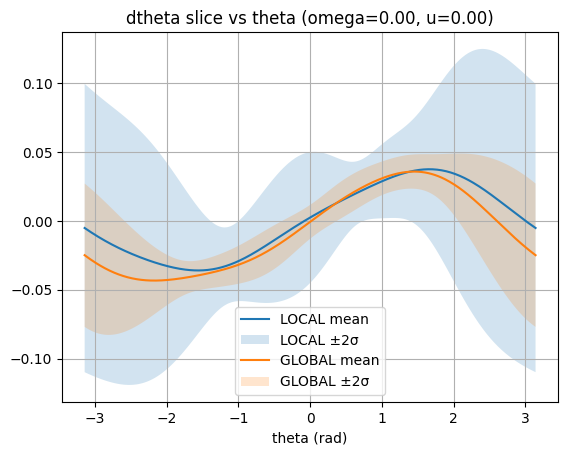

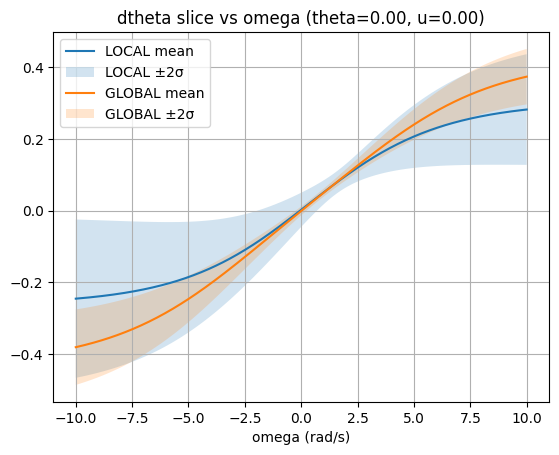

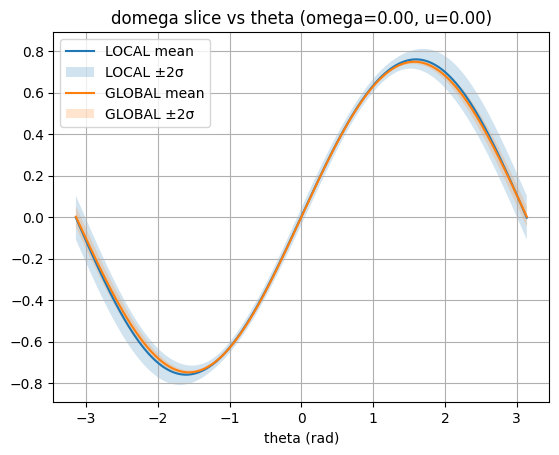

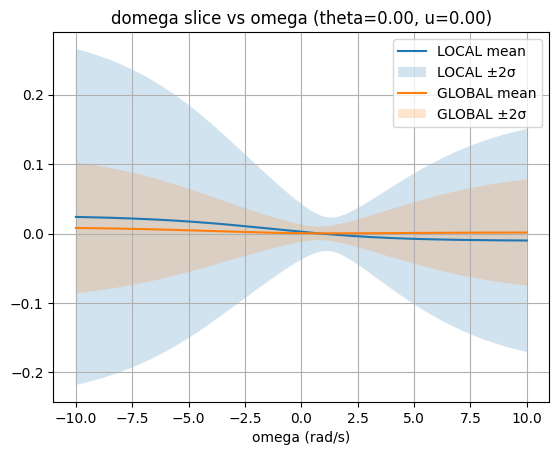

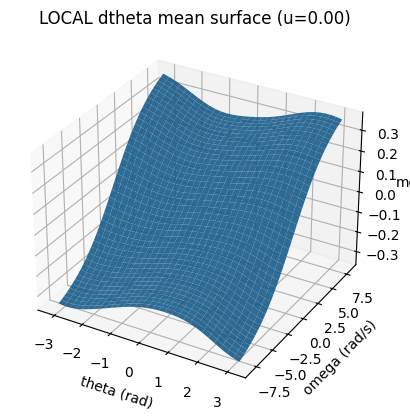

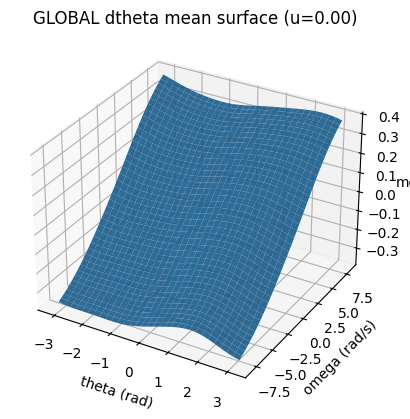

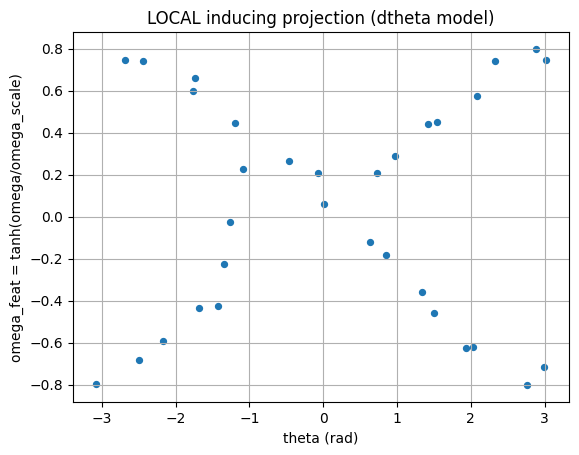

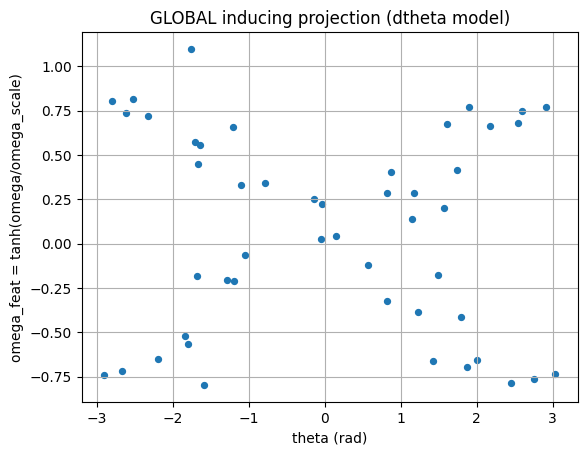

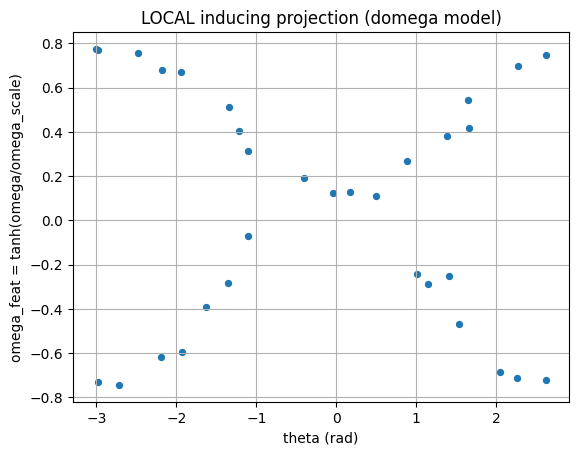

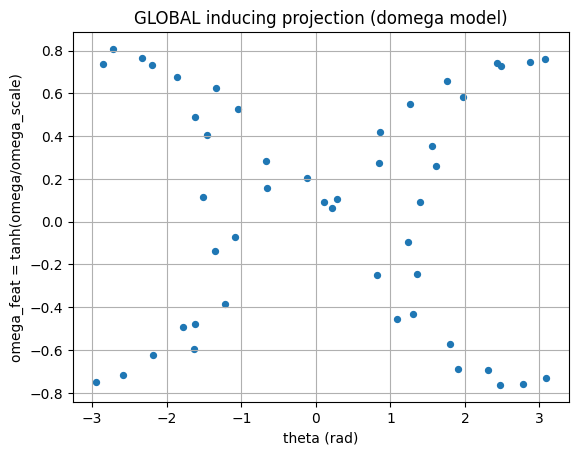

In [7]:
# ===========================
# Cell 6 — GP VISUALIZATION (SAME STYLE) + 3D plot + inducing points
#   ✅ Slice plot: mean ± 2σ vs theta, omega (fix u)
#   ✅ 3D surface: mean over (theta, omega) grid
#   ✅ Show inducing points projected into (theta, omega_feat)
#   ✅ Compare LOCAL vs GLOBAL side-by-side
# ===========================

import numpy as np
import matplotlib.pyplot as plt

# ----------------------------
# helpers to build grids
# ----------------------------
def make_grid_theta_omega(
    theta_min=-np.pi,
    theta_max=np.pi,
    omega_min=-8.0,
    omega_max=8.0,
    n_theta=81,
    n_omega=61,
):
    thetas = np.linspace(theta_min, theta_max, n_theta)
    omegas = np.linspace(omega_min, omega_max, n_omega)
    TT, WW = np.meshgrid(thetas, omegas)  # shape [n_omega, n_theta]
    return thetas, omegas, TT, WW


def grid_features(TT, WW, u_fixed, omega_scale):
    """
    TT,WW shape [H,W]
    returns Xgrid shape [H*W, 4]
    """
    H, W = TT.shape
    Xg = np.zeros((H * W, 4), dtype=np.float64)
    k = 0
    for i in range(H):
        for j in range(W):
            th = float(TT[i, j])
            om = float(WW[i, j])
            Xg[k] = theta_omega_to_features(th, om, float(u_fixed), omega_scale=omega_scale)
            k += 1
    return Xg


def model_predict_mean_std(model, Xnew):
    """
    Use cached predict (FAST).
    Returns numpy mean, std.
    """
    mu_tf, var_tf = model.predict_f_cached(Xnew, full_cov=False)
    mu = mu_tf.numpy().reshape(-1)
    var = var_tf.numpy().reshape(-1)
    std = np.sqrt(np.maximum(var, 1e-12))
    return mu, std


def plot_slice_theta(
    model_L,
    model_G,
    title="dtheta",
    omega0=0.0,
    u0=0.0,
    omega_scale=8.0,
    n=400,
):
    thetas = np.linspace(-np.pi, np.pi, n)
    omegas = np.full_like(thetas, float(omega0), dtype=np.float64)
    X = np.zeros((n, 4), dtype=np.float64)
    for i in range(n):
        X[i] = theta_omega_to_features(thetas[i], omegas[i], float(u0), omega_scale=omega_scale)

    muL, stdL = model_predict_mean_std(model_L, X)
    muG, stdG = model_predict_mean_std(model_G, X)

    plt.figure()
    plt.plot(thetas, muL, label="LOCAL mean")
    plt.fill_between(thetas, muL - 2 * stdL, muL + 2 * stdL, alpha=0.20, label="LOCAL ±2σ")

    plt.plot(thetas, muG, label="GLOBAL mean")
    plt.fill_between(thetas, muG - 2 * stdG, muG + 2 * stdG, alpha=0.20, label="GLOBAL ±2σ")

    plt.title(f"{title} slice vs theta (omega={omega0:.2f}, u={u0:.2f})")
    plt.xlabel("theta (rad)")
    plt.grid(True)
    plt.legend()
    plt.show()


def plot_slice_omega(
    model_L,
    model_G,
    title="dtheta",
    theta0=0.0,
    u0=0.0,
    omega_scale=8.0,
    omega_min=-10.0,
    omega_max=10.0,
    n=400,
):
    omegas = np.linspace(omega_min, omega_max, n)
    thetas = np.full_like(omegas, float(theta0), dtype=np.float64)

    X = np.zeros((n, 4), dtype=np.float64)
    for i in range(n):
        X[i] = theta_omega_to_features(thetas[i], omegas[i], float(u0), omega_scale=omega_scale)

    muL, stdL = model_predict_mean_std(model_L, X)
    muG, stdG = model_predict_mean_std(model_G, X)

    plt.figure()
    plt.plot(omegas, muL, label="LOCAL mean")
    plt.fill_between(omegas, muL - 2 * stdL, muL + 2 * stdL, alpha=0.20, label="LOCAL ±2σ")

    plt.plot(omegas, muG, label="GLOBAL mean")
    plt.fill_between(omegas, muG - 2 * stdG, muG + 2 * stdG, alpha=0.20, label="GLOBAL ±2σ")

    plt.title(f"{title} slice vs omega (theta={theta0:.2f}, u={u0:.2f})")
    plt.xlabel("omega (rad/s)")
    plt.grid(True)
    plt.legend()
    plt.show()


def plot_surface_3d(
    model,
    title="dtheta mean",
    u_fixed=0.0,
    omega_scale=8.0,
    theta_min=-np.pi,
    theta_max=np.pi,
    omega_min=-8.0,
    omega_max=8.0,
    n_theta=61,
    n_omega=41,
):
    # grid in theta, omega
    thetas, omegas, TT, WW = make_grid_theta_omega(
        theta_min=theta_min, theta_max=theta_max,
        omega_min=omega_min, omega_max=omega_max,
        n_theta=n_theta, n_omega=n_omega
    )

    Xg = grid_features(TT, WW, u_fixed=u_fixed, omega_scale=omega_scale)
    mu, std = model_predict_mean_std(model, Xg)

    MU = mu.reshape((len(omegas), len(thetas)))  # [n_omega, n_theta]

    # plot 3D
    from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
    fig = plt.figure()
    ax = fig.add_subplot(111, projection="3d")
    ax.plot_surface(TT, WW, MU, linewidth=0, antialiased=True, alpha=0.9)

    ax.set_title(f"{title} (u={u_fixed:.2f})")
    ax.set_xlabel("theta (rad)")
    ax.set_ylabel("omega (rad/s)")
    ax.set_zlabel("mean")
    plt.show()


def plot_inducing_projection(model, omega_scale, title="inducing projection"):
    """
    Project inducing points Z = [sinθ, cosθ, omega_feat, u]
    back to (theta, omega_feat) for visualization.
    """
    Z = model.inducing_variable.Z.numpy()
    sin_th = Z[:, 0]
    cos_th = Z[:, 1]
    omega_feat = Z[:, 2]
    u = Z[:, 3]

    theta = np.arctan2(sin_th, cos_th)  # [-pi, pi]
    theta = np.array([wrap_pi(t) for t in theta], dtype=np.float64)

    plt.figure()
    plt.scatter(theta, omega_feat, s=18)
    plt.title(title)
    plt.xlabel("theta (rad)")
    plt.ylabel("omega_feat = tanh(omega/omega_scale)")
    plt.grid(True)
    plt.show()


# ============================================================
# Run plots (LOCAL vs GLOBAL)
# ============================================================

U_PLOT = 0.0

# ---- dtheta slices ----
plot_slice_theta(
    model_L=m_dth_L,
    model_G=m_dth_G,
    title="dtheta",
    omega0=0.0,
    u0=U_PLOT,
    omega_scale=omega_scale,
)

plot_slice_omega(
    model_L=m_dth_L,
    model_G=m_dth_G,
    title="dtheta",
    theta0=0.0,
    u0=U_PLOT,
    omega_scale=omega_scale,
    omega_min=-10.0,
    omega_max=10.0,
)

# ---- domega slices ----
plot_slice_theta(
    model_L=m_dom_L,
    model_G=m_dom_G,
    title="domega",
    omega0=0.0,
    u0=U_PLOT,
    omega_scale=omega_scale,
)

plot_slice_omega(
    model_L=m_dom_L,
    model_G=m_dom_G,
    title="domega",
    theta0=0.0,
    u0=U_PLOT,
    omega_scale=omega_scale,
    omega_min=-10.0,
    omega_max=10.0,
)

# ---- 3D surface (mean) ----
plot_surface_3d(
    model=m_dth_L,
    title="LOCAL dtheta mean surface",
    u_fixed=U_PLOT,
    omega_scale=omega_scale,
)

plot_surface_3d(
    model=m_dth_G,
    title="GLOBAL dtheta mean surface",
    u_fixed=U_PLOT,
    omega_scale=omega_scale,
)

# ---- inducing projections ----
plot_inducing_projection(m_dth_L, omega_scale, title="LOCAL inducing projection (dtheta model)")
plot_inducing_projection(m_dth_G, omega_scale, title="GLOBAL inducing projection (dtheta model)")

plot_inducing_projection(m_dom_L, omega_scale, title="LOCAL inducing projection (domega model)")
plot_inducing_projection(m_dom_G, omega_scale, title="GLOBAL inducing projection (domega model)")


In [8]:
# ===========================
# Cell 7 — MPPI planner (CACHED) for Pendulum-v1 (DUAL-GP compatible)
#   ✅ Uses YOUR GP features: X=[sinθ, cosθ, ω_feat, u]
#   ✅ Uses YOUR cached prediction: predict_f_cached()
#   ✅ Returns:
#       - u0 (first action to execute)
#       - updated u_nom rollout (shifted nominal)
#       - info dict
#       - u_candidates (first-step actions from samples)  <-- for inducing-cloud trick
#
#   Dual GP usage:
#     Pass in either (LOCAL) or (GLOBAL) model pair:
#       m_dth = m_dth_L or m_dth_G
#       m_dom = m_dom_L or m_dom_G
# ===========================

import numpy as np
import tensorflow as tf


# ----------------------------
# MPPI hyperparams (same style)
# ----------------------------
HORIZON     = 30
NUM_SAMPLES = 96
NOISE_SIGMA = 0.6
LAMBDA      = 1.0
GAMMA       = 0.99


# ----------------------------
# rollout dynamics via GP
# ----------------------------
def gp_dynamics_step(m_dth, m_dom, theta, omega, u, omega_scale):
    """
    One-step prediction using GP models:
      dtheta ~ GP_dtheta(x)
      domega ~ GP_domega(x)
    x = [sinθ, cosθ, ω_feat, u]
    """
    X = theta_omega_to_features(theta, omega, u, omega_scale=omega_scale)[None, :]  # [1,4]

    mu_dth, var_dth = m_dth.predict_f_cached(X, full_cov=False)
    mu_dom, var_dom = m_dom.predict_f_cached(X, full_cov=False)

    dtheta = float(mu_dth.numpy().reshape(-1)[0])
    domega = float(mu_dom.numpy().reshape(-1)[0])

    theta_next = wrap_pi(theta + dtheta)
    omega_next = omega + domega
    return theta_next, omega_next


# ----------------------------
# cost function (clean + editable)
# ----------------------------
def pendulum_cost(theta, omega, u, explore_bonus=0.0, w_theta=2.0, w_omega=0.2, w_u=0.02):
    """
    Default pendulum cost:
      - penalize theta away from upright (theta=0)
      - penalize angular velocity
      - small control penalty
      - optional exploration bonus (subtract from cost)
    """
    c = 0.0
    c += w_theta * (theta ** 2)
    c += w_omega * (omega ** 2)
    c += w_u * (u ** 2)
    c -= explore_bonus
    return float(c)


def gp_uncertainty_bonus(m_dth, m_dom, theta, omega, u, omega_scale):
    """
    Exploration bonus: sum of predictive stds at (theta,omega,u)
    """
    X = theta_omega_to_features(theta, omega, u, omega_scale=omega_scale)[None, :]

    _, var_dth = m_dth.predict_f_cached(X, full_cov=False)
    _, var_dom = m_dom.predict_f_cached(X, full_cov=False)

    std_dth = float(np.sqrt(np.maximum(var_dth.numpy().reshape(-1)[0], 1e-12)))
    std_dom = float(np.sqrt(np.maximum(var_dom.numpy().reshape(-1)[0], 1e-12)))
    return std_dth + std_dom


# ----------------------------
# MPPI main planner
# ----------------------------
def mppi_plan_action_uncertainty(
    m_dth,
    m_dom,
    theta0,
    omega0,
    u_nom,
    omega_scale,
    horizon=HORIZON,
    num_samples=NUM_SAMPLES,
    noise_sigma=NOISE_SIGMA,
    lam=LAMBDA,
    gamma=GAMMA,
    explore=True,
    explore_w=1.0,
    rng=None,
):
    """
    MPPI with explore->exploit mode:
      explore=True  => adds uncertainty bonus to encourage visiting unknown regions
      explore=False => pure exploit, minimize task cost only
    """
    if rng is None:
        rng = np.random.default_rng(0)

    u_nom = np.asarray(u_nom, dtype=np.float64).copy()
    assert u_nom.shape[0] == horizon

    # sample noise: [K, H]
    eps = rng.normal(loc=0.0, scale=noise_sigma, size=(num_samples, horizon)).astype(np.float64)

    # sample actions: u_k = clip(u_nom + eps)
    U = u_nom[None, :] + eps
    U = np.clip(U, U_MIN, U_MAX)

    costs = np.zeros((num_samples,), dtype=np.float64)

    # rollout each sample
    for k in range(num_samples):
        th = float(theta0)
        om = float(omega0)
        total = 0.0
        disc = 1.0

        for t in range(horizon):
            u = float(U[k, t])

            bonus = 0.0
            if explore:
                bonus = explore_w * gp_uncertainty_bonus(m_dth, m_dom, th, om, u, omega_scale)

            total += disc * pendulum_cost(th, om, u, explore_bonus=bonus)
            disc *= gamma

            th, om = gp_dynamics_step(m_dth, m_dom, th, om, u, omega_scale)

        costs[k] = total

    # MPPI weights
    beta = np.min(costs)
    w = np.exp(-(costs - beta) / lam)
    w = w / (np.sum(w) + 1e-12)

    # update nominal by weighted average of samples
    u_new = np.sum(w[:, None] * U, axis=0)

    # return action = first element
    u0 = float(u_new[0])

    # shift nominal for next call
    u_nom_next = np.roll(u_new, -1)
    u_nom_next[-1] = 0.0

    info = dict(
        costs=costs,
        w=w,
        beta=beta,
        explore=explore,
        explore_w=explore_w,
    )

    # u_candidates = the sampled first-step actions (for inducing-cloud trick)
    u_candidates = U[:, 0].copy()

    return u0, u_nom_next, info, u_candidates


# ----------------------------
# quick sanity test (no env run)
# ----------------------------
u_nom0 = np.zeros(HORIZON, dtype=np.float64)

# pick LOCAL by default for MPPI
u0, u_nom1, info, u_cand = mppi_plan_action_uncertainty(
    m_dth_L, m_dom_L,
    theta0=0.1,
    omega0=0.0,
    u_nom=u_nom0,
    omega_scale=omega_scale,
    explore=True,
    rng=np.random.default_rng(0),
)

print("✅ MPPI sanity:")
print("u0:", u0, "u_nom_next[0:5]:", u_nom1[:5])
print("u_candidates shape:", u_cand.shape)


✅ MPPI sanity:
u0: -1.1545239460739758 u_nom_next[0:5]: [-0.96226607  0.37029607 -0.09194296 -1.10090489 -0.33050415]
u_candidates shape: (96,)


In [12]:
# ===========================
# Cell 8 — ONLINE IN 1 EPISODE (DUAL-GP STREAMING)
#
#   MPPI uses LOCAL models (specialist / high-resolution near rollout region)
#   Streaming updates update BOTH:
#     ✅ LOCAL  (fixed inducing budget M_LOCAL, k-center + candidate cloud)
#     ✅ GLOBAL (memory model, inducing budget slowly grows up to M_GLOBAL_MAX)
#
#   ✅ OPTIONAL: Eval after each update (toggle with DO_EVAL_AFTER_UPDATE)
#   ✅ Plotly interactive plots for traces + update metrics
# ===========================

import numpy as np
import time
import plotly.graph_objects as go
from PIL import Image

# ===========================
# ✅ Toggle eval after update
# ===========================
DO_EVAL_AFTER_UPDATE = False   # <----- SET TRUE if you want eval every update


# ----------------------------
# k-center inducing selection (same as your style)
# ----------------------------
def choose_Z_kcenter(Z_old, X_batch, M, X_mppi_cand=None, rng=None):
    """
    Build inducing points Z_new using greedy k-center over a candidate set:
      candidates = [Z_old; X_batch; X_mppi_cand]
    """
    if rng is None:
        rng = np.random.default_rng(0)

    Z_old = np.asarray(Z_old, dtype=np.float64)
    X_batch = np.asarray(X_batch, dtype=np.float64)

    cand = [Z_old, X_batch]
    if X_mppi_cand is not None:
        X_mppi_cand = np.asarray(X_mppi_cand, dtype=np.float64)
        cand.append(X_mppi_cand)
    C = np.vstack(cand).astype(np.float64)

    if C.shape[0] <= M:
        return C.copy()

    first = int(rng.integers(0, C.shape[0]))
    Z = [C[first]]
    dist2 = np.sum((C - Z[0][None, :]) ** 2, axis=1)

    for _ in range(1, M):
        idx = int(np.argmax(dist2))
        Z.append(C[idx])
        d2_new = np.sum((C - C[idx][None, :]) ** 2, axis=1)
        dist2 = np.minimum(dist2, d2_new)

    return np.array(Z, dtype=np.float64)


# ----------------------------
# Candidate cloud for local inducing coverage (your trick)
# ----------------------------
def make_mppi_candidate_cloud(theta_hist, omega_hist, u_candidates, omega_scale, S=64, rng=None):
    """
    Sample recent executed (theta,omega) and pair with MPPI candidate first actions
    -> Xcand used ONLY to influence inducing points (coverage along MPPI proposals)
    """
    if rng is None:
        rng = np.random.default_rng(0)

    theta_hist = np.asarray(theta_hist, dtype=np.float64)
    omega_hist = np.asarray(omega_hist, dtype=np.float64)
    u_candidates = np.asarray(u_candidates, dtype=np.float64)

    if len(theta_hist) == 0:
        return None

    S = min(S, len(theta_hist))
    idxS = rng.choice(len(theta_hist), size=S, replace=False)
    a = rng.choice(u_candidates, size=S, replace=True)

    Xcand = np.zeros((S, 4), dtype=np.float64)
    for i, (th, om, u) in enumerate(zip(theta_hist[idxS], omega_hist[idxS], a)):
        Xcand[i] = theta_omega_to_features(th, om, float(u), omega_scale=omega_scale)
    return Xcand


# ----------------------------
# Streaming update wrapper (single model)
# ----------------------------
def streaming_update_once(
    model_old,
    X_batch,
    y_batch,
    Z_new,
    train_iters=120,
    lr=0.02,
    freeze_kernel=True,
):
    """
    Build new OSGPR_VFE using old summary + batch data, with new inducing Z_new.
    """
    mu_old, Su_old, Kaa_old, Z_old = extract_summary_from_model(model_old)
    kern = model_old.kernel

    model_new = OSGPR_VFE(
        data=(X_batch, y_batch),
        kernel=kern,
        mu_old=mu_old,
        Su_old=Su_old,
        Kaa_old=Kaa_old,
        Z_old=Z_old,
        Z=Z_new,
    )

    model_new.likelihood.variance.assign(model_old.likelihood.variance.numpy())

    if freeze_kernel:
        gpflow.set_trainable(model_new.kernel, False)

    dt, loss = train_osgpr(model_new, iters=train_iters, lr=lr)
    model_new.build_predict_cache()

    return model_new, dict(train_time=float(dt), loss=float(loss))


# ----------------------------
# GLOBAL inducing grow helper
# ----------------------------
def global_inducing_next_Z(
    Z_old,
    X_batch,
    M_target,
    keep_frac=0.90,
    rng=None,
):
    """
    GLOBAL policy:
      keep most of old Z (memory) + sprinkle points from new batch
      and allow total M to grow over time up to M_GLOBAL_MAX.
    """
    return choose_inducing_keep_old(Z_old, X_batch, M=M_target, keep_frac=keep_frac, rng=rng)


# ----------------------------
# Success condition (upright + stable)
# ----------------------------
def is_success(theta, omega, theta_tol=0.12, omega_tol=0.5):
    return (abs(theta) < theta_tol) and (abs(omega) < omega_tol)


# ----------------------------
# ✅ Evaluation episode (exploit-only, NO updates)
# ----------------------------
def run_eval_episode(
    m_dth_local,
    m_dom_local,
    omega_scale,
    seed=123,
    max_steps=1000,
    success_streak_need=100,
):
    """
    Evaluation = exploit-only MPPI using LOCAL models, no exploration bonus, no GP updates.
    """
    env = make_env(render_mode=None, seed=seed, max_episode_steps=max_steps)
    obs, info = env.reset(seed=seed)
    theta, omega = obs_to_theta_omega(obs)

    u_nom = np.zeros(HORIZON, dtype=np.float64)
    rng = np.random.default_rng(seed)

    streak = 0
    t0 = time.time()

    for t in range(max_steps):
        u, u_nom, info_mppi, _ = mppi_plan_action_uncertainty(
            m_dth_local,
            m_dom_local,
            theta0=theta,
            omega0=omega,
            u_nom=u_nom,
            omega_scale=omega_scale,
            horizon=HORIZON,
            num_samples=NUM_SAMPLES,
            noise_sigma=NOISE_SIGMA,
            lam=LAMBDA,
            gamma=GAMMA,
            explore=False,   # exploit-only
            rng=rng,
        )

        obs2, r, terminated, truncated, info = env.step(np.array([u], dtype=np.float32))
        theta, omega = obs_to_theta_omega(obs2)

        if is_success(theta, omega):
            streak += 1
        else:
            streak = 0

        if streak >= success_streak_need:
            env.close()
            return dict(success=True, steps=t + 1, wall=time.time() - t0)

        if terminated or truncated:
            break

    env.close()
    return dict(success=False, steps=max_steps, wall=time.time() - t0)


# ----------------------------
# ONLINE episode runner (DUAL GP streaming)
# ----------------------------
def run_online_episode_dual_streaming(
    seed=0,
    max_steps=1000,
    render=True,
    frame_stride=2,
    resize=(720, 450),
    fps=20,
    # MPPI schedule
    explore_steps=120,
    explore_w=1.0,
    # update schedule
    min_steps_before_update=20,
    update_every=20,
    online_batch=256,
    # LOCAL inducing
    m_local=M_LOCAL,
    mppi_cloud_S=48,
    # GLOBAL inducing growth
    m_global_init=M_GLOBAL_INIT,
    m_global_max=M_GLOBAL_MAX,
    m_global_grow_every=M_GLOBAL_GROW_EVERY,
    m_global_grow_by=M_GLOBAL_GROW_BY,
    global_keep_frac=0.90,
    # training
    train_iters=120,
    lr=0.02,
    freeze_kernel_after_init=True,
    # eval (only used if DO_EVAL_AFTER_UPDATE=True)
    eval_seed=123,
    eval_max_steps=400,
    eval_success_streak_need=50,
):
    rng = np.random.default_rng(seed)

    env = make_env(render_mode="rgb_array" if render else None, seed=seed, max_episode_steps=max_steps)
    obs, info = env.reset(seed=seed)
    theta, omega = obs_to_theta_omega(obs)

    u_nom = np.zeros(HORIZON, dtype=np.float64)

    X_exec, y_dth_exec, y_dom_exec = [], [], []
    theta_hist, omega_hist, u_hist = [], [], []
    frames = []
    update_logs = []

    streak = 0
    NEED_STREAK = 100

    global m_dth_L, m_dom_L, m_dth_G, m_dom_G

    M_global_now = int(m_dth_G.inducing_variable.Z.numpy().shape[0])
    update_count = 0

    t0 = time.time()

    for t in range(max_steps):
        theta_hist.append(theta)
        omega_hist.append(omega)

        explore = (t < explore_steps)

        # MPPI plan (LOCAL)
        u, u_nom, info_mppi, u_candidates = mppi_plan_action_uncertainty(
            m_dth_L, m_dom_L,
            theta0=theta,
            omega0=omega,
            u_nom=u_nom,
            omega_scale=omega_scale,
            horizon=HORIZON,
            num_samples=NUM_SAMPLES,
            noise_sigma=NOISE_SIGMA,
            lam=LAMBDA,
            gamma=GAMMA,
            explore=explore,
            explore_w=explore_w,
            rng=rng,
        )

        obs2, r, terminated, truncated, info = env.step(np.array([u], dtype=np.float32))
        theta2, omega2 = obs_to_theta_omega(obs2)

        dtheta = wrap_pi(theta2 - theta)
        domega = float(omega2 - omega)

        X_exec.append(theta_omega_to_features(theta, omega, u, omega_scale=omega_scale))
        y_dth_exec.append(dtheta)
        y_dom_exec.append(domega)
        u_hist.append(float(u))

        if render and (t % frame_stride == 0):
            frame = env.render()
            if frame is not None:
                img = Image.fromarray(frame).resize(resize, resample=Image.BILINEAR)
                frames.append(np.array(img))

        theta, omega = theta2, omega2

        if is_success(theta, omega):
            streak += 1
        else:
            streak = 0

        # =========================
        # Streaming update
        # =========================
        if (t >= min_steps_before_update) and ((t + 1) % update_every == 0):
            X_arr = np.asarray(X_exec, dtype=np.float64)
            yth_arr = np.asarray(y_dth_exec, dtype=np.float64).reshape(-1, 1)
            yom_arr = np.asarray(y_dom_exec, dtype=np.float64).reshape(-1, 1)

            Xb = X_arr[-online_batch:]
            yth_b = yth_arr[-online_batch:]
            yom_b = yom_arr[-online_batch:]

            # Local inducing
            Xcand = make_mppi_candidate_cloud(
                theta_hist=np.asarray(theta_hist, dtype=np.float64),
                omega_hist=np.asarray(omega_hist, dtype=np.float64),
                u_candidates=u_candidates,
                omega_scale=omega_scale,
                S=mppi_cloud_S,
                rng=rng,
            )

            ZL_old_th = m_dth_L.inducing_variable.Z.numpy()
            ZL_old_om = m_dom_L.inducing_variable.Z.numpy()
            ZL_new_th = choose_Z_kcenter(ZL_old_th, Xb, M=m_local, X_mppi_cand=Xcand, rng=rng)
            ZL_new_om = choose_Z_kcenter(ZL_old_om, Xb, M=m_local, X_mppi_cand=Xcand, rng=rng)

            # Global inducing grow
            update_count += 1
            grow_now = (update_count % int(m_global_grow_every) == 0)
            if grow_now and (M_global_now < int(m_global_max)):
                M_global_now = int(min(m_global_max, M_global_now + int(m_global_grow_by)))

            ZG_old_th = m_dth_G.inducing_variable.Z.numpy()
            ZG_old_om = m_dom_G.inducing_variable.Z.numpy()
            ZG_new_th = global_inducing_next_Z(ZG_old_th, Xb, M_target=M_global_now, keep_frac=global_keep_frac, rng=rng)
            ZG_new_om = global_inducing_next_Z(ZG_old_om, Xb, M_target=M_global_now, keep_frac=global_keep_frac, rng=rng)

            # Train all four models
            t_up = time.time()

            m_dth_L_new, log_L_th = streaming_update_once(
                m_dth_L, Xb, yth_b, ZL_new_th,
                train_iters=train_iters, lr=lr,
                freeze_kernel=freeze_kernel_after_init
            )
            m_dom_L_new, log_L_om = streaming_update_once(
                m_dom_L, Xb, yom_b, ZL_new_om,
                train_iters=train_iters, lr=lr,
                freeze_kernel=freeze_kernel_after_init
            )

            m_dth_G_new, log_G_th = streaming_update_once(
                m_dth_G, Xb, yth_b, ZG_new_th,
                train_iters=train_iters, lr=lr,
                freeze_kernel=freeze_kernel_after_init
            )
            m_dom_G_new, log_G_om = streaming_update_once(
                m_dom_G, Xb, yom_b, ZG_new_om,
                train_iters=train_iters, lr=lr,
                freeze_kernel=freeze_kernel_after_init
            )

            m_dth_L, m_dom_L = m_dth_L_new, m_dom_L_new
            m_dth_G, m_dom_G = m_dth_G_new, m_dom_G_new

            update_wall = time.time() - t_up

            # -------- OPTIONAL EVAL --------
            eval_res = None
            if DO_EVAL_AFTER_UPDATE:
                eval_res = run_eval_episode(
                    m_dth_L, m_dom_L,
                    omega_scale=omega_scale,
                    seed=eval_seed,
                    max_steps=eval_max_steps,
                    success_streak_need=eval_success_streak_need,
                )

            upd = dict(
                t=int(t),
                explore=bool(explore),
                X_batch=int(len(Xb)),
                update_wall=float(update_wall),

                M_local=int(m_local),
                M_global=int(M_global_now),

                L_th_time=float(log_L_th["train_time"]),
                L_om_time=float(log_L_om["train_time"]),
                L_th_loss=float(log_L_th["loss"]),
                L_om_loss=float(log_L_om["loss"]),

                G_th_time=float(log_G_th["train_time"]),
                G_om_time=float(log_G_om["train_time"]),
                G_th_loss=float(log_G_th["loss"]),
                G_om_loss=float(log_G_om["loss"]),
            )

            if eval_res is not None:
                upd.update(dict(
                    eval_success=bool(eval_res["success"]),
                    eval_steps=int(eval_res["steps"]),
                    eval_wall=float(eval_res["wall"]),
                ))

            update_logs.append(upd)

            print(f"[Update @ t={t}] explore={explore}  "
                  f"LOCAL(loss_th={upd['L_th_loss']:.3f}, loss_om={upd['L_om_loss']:.3f})  "
                  f"GLOBAL(M={upd['M_global']}, loss_th={upd['G_th_loss']:.3f}, loss_om={upd['G_om_loss']:.3f})  "
                  f"upd_wall={upd['update_wall']:.2f}s")

            if eval_res is not None:
                print(f"   [Eval] success={upd['eval_success']} steps={upd['eval_steps']} wall={upd['eval_wall']:.2f}s")

        # stop if stabilized
        if streak >= NEED_STREAK:
            print(f"✅ SUCCESS: upright stable for {NEED_STREAK} steps at t={t}.")
            break

        if terminated or truncated:
            break

    env.close()

    wall = time.time() - t0
    print(f"Episode finished. steps={t+1}, wall={wall:.2f}s, updates={len(update_logs)}")

    html = None
    if render and len(frames) > 0:
        html = _encode_frames_to_jshtml(frames, fps=fps)

    logs = dict(
        theta=np.asarray(theta_hist, dtype=np.float64),
        omega=np.asarray(omega_hist, dtype=np.float64),
        u=np.asarray(u_hist, dtype=np.float64),
        update_logs=update_logs,
        wall=float(wall),
        steps=int(t + 1),
    )
    return logs, html


# ----------------------------
# Run 1 online episode (DUAL)
# ----------------------------
logs, html = run_online_episode_dual_streaming(
    seed=0,
    max_steps=600,
    render=True,          # set False for speed
    frame_stride=2,
    resize=(720, 450),
    fps=20,
    explore_steps=120,
    explore_w=1.0,

    min_steps_before_update=60,
    update_every=40,
    online_batch=256,

    m_local=M_LOCAL,
    mppi_cloud_S=48,

    m_global_init=M_GLOBAL_INIT,
    m_global_max=M_GLOBAL_MAX,
    m_global_grow_every=M_GLOBAL_GROW_EVERY,
    m_global_grow_by=M_GLOBAL_GROW_BY,
    global_keep_frac=0.90,

    train_iters=80,
    lr=0.02,
    freeze_kernel_after_init=True,

    eval_seed=123,
    eval_max_steps=400,
    eval_success_streak_need=50,
)

if html is not None:
    display(html)


# ===========================
# ✅ Plotly interactive plots
# ===========================
theta_tr = logs["theta"]
omega_tr = logs["omega"]
u_tr     = logs["u"]

# ---- Trace plot ----
fig1 = go.Figure()
fig1.add_trace(go.Scatter(y=theta_tr, mode="lines", name="theta"))
fig1.add_trace(go.Scatter(y=omega_tr, mode="lines", name="omega"))
fig1.update_layout(
    title="Online Episode Trace (theta, omega)",
    xaxis_title="t",
    yaxis_title="value",
)
fig1.show()

fig2 = go.Figure()
fig2.add_trace(go.Scatter(y=u_tr, mode="lines", name="u"))
fig2.update_layout(
    title="Actions",
    xaxis_title="t",
    yaxis_title="u",
)
fig2.show()

# ---- Update metrics ----
upd = logs["update_logs"]
if len(upd) > 0:
    xs = [u["t"] for u in upd]

    fig3 = go.Figure()
    fig3.add_trace(go.Scatter(x=xs, y=[u["update_wall"] for u in upd], mode="lines+markers", name="update_wall"))
    fig3.update_layout(
        title="Streaming update wall time vs step",
        xaxis_title="update step t",
        yaxis_title="seconds",
    )
    fig3.show()

    fig4 = go.Figure()
    fig4.add_trace(go.Scatter(x=xs, y=[u["M_global"] for u in upd], mode="lines+markers", name="M_global"))
    fig4.update_layout(
        title="GLOBAL inducing size over updates",
        xaxis_title="update step t",
        yaxis_title="M_global",
    )
    fig4.show()

    # Only plot eval if present
    if ("eval_steps" in upd[0]):
        fig5 = go.Figure()
        fig5.add_trace(go.Scatter(x=xs, y=[u["eval_steps"] for u in upd], mode="lines+markers", name="eval_steps"))
        fig5.update_layout(
            title="Eval steps-to-success after each update (lower is better)",
            xaxis_title="update step t",
            yaxis_title="eval steps",
        )
        fig5.show()

        print("Eval success flags:", [u["eval_success"] for u in upd])


[Update @ t=79] explore=True  LOCAL(loss_th=-222.150, loss_om=-221.855)  GLOBAL(M=56, loss_th=-305.343, loss_om=-312.687)  upd_wall=2.97s
[Update @ t=119] explore=True  LOCAL(loss_th=-416.950, loss_om=-409.745)  GLOBAL(M=64, loss_th=-547.935, loss_om=-557.464)  upd_wall=3.32s
✅ SUCCESS: upright stable for 100 steps at t=133.
Episode finished. steps=134, wall=5442.31s, updates=2
